## Example Q1: Configuring a Channel Library from Scratch  
This example notebook shows how, using QGL, one can configure a measurement system. All configuration occurs within the notebook, but interfaces with the QGL `ChannelLibrary` object that uses the `bbndb` package database backend.

(c) Raytheon BBN Technologies 2018

### Creating a Channel Library 

The `AWGDir` environment variable is used to indicate where QGL will store it's output sequence files. First we load the QGL module. It defaults to a temporary directory as provided by Python's `tempfile` module.

In [1]:
from QGL import *

Defaulting to temporary directory for AWG sequence file outputs.


Next we instantiate the channel library. By default `bbndb` will use an sqlite database at the location specified by the `BBN_DB` environment variabe, but we override this behavior below in order to use a temporary in memory database for testing purposes.

In [2]:
cl = ChannelLibrary(db_resource_name=":memory:")

The channel library has a number of convenience functions defined for create instruments and qubits, as well as functions to define the relationships between them. Let us create a qubit first:

In [3]:
q1 = cl.new_qubit("q1")

Later on we will see how to save and load other versions of the channel library, so remember that *this reference will become stale if other library versions are loaded*. After creation it is safest to refer to channels using keyword syntax on the channel library, i.e. `cl["q1"]`. We'll discuss this more later. Now we create some instrumentation: AWGs, a digitizer, and some microwave sources

In [4]:
# Most calls required label and address
aps2_1 = cl.new_APS2("BBNAPS1", address="192.168.5.101") 
aps2_2 = cl.new_APS2("BBNAPS2", address="192.168.5.102")
dig_1  = cl.new_X6("X6_1", address=0)

There is more general syntax for arbitrary instruments:

In [5]:
# Label, instrument type, address, and an additional config parameter
h1 = cl.new_source("Holz1", "HolzworthHS9000", "HS9004A-009-1", power=-30)
h2 = cl.new_source("Holz2", "HolzworthHS9000", "HS9004A-009-2", power=-30) 

Now we want to define which instruments control what.

In [6]:
# Qubit q1 is controlled by AWG aps2_1, and uses microwave source h1
cl.set_control(q1, aps2_1, generator=h1)
# Qubit q1 is measured by AWG aps2_2 and digitizer dig_1, and uses microwave source h2
cl.set_measure(q1, aps2_2, dig_1["raw-1-1"], generator=h2)
# The AWG aps2_1 is the master AWG, and distributes a synchronization trigger on its second marker channel
cl.set_master(aps2_1, aps2_1.ch("m2"))

These objects are linked to one another, and belong to a relational database. Therefore once can easily drill through the heirarchy using typical "dot" attribute access. i.e. we can configure the sidebanding of q1 using the following:

In [7]:
cl["q1"].measure_chan.frequency = 10e6

All of the object above have been added to the current database session, but must be committed in order to be made permanent. That can be done as follows:

In [8]:
cl.commit()

At this point the channel database is automatically saved to the "working" copy. All of the current channel libraries can be listed  (along with their ID and date stamp) with:

In [9]:
cl.ls()

id,Year,Date,Time,Name
1,2019,Mar. 08,10:34:37 AM,working


The channel library will attempt to prevent you from creating redundant objects, e.g.:

In [10]:
q1 = cl.new_qubit("q1")

A database item with the name q1 already exists. Returning this existing item instead.


In [11]:
cl.set_measure(q1, aps2_2, dig_1["demodulated-1-1"], generator=h2)

The measurement M-q1 already exists: using this measurement.
The Receiver trigger ReceiverTrig-q1 already exists: using this channel.


Let's plot the pulse files for a Rabi sequence (giving a directory for storing AWG information).

In [12]:
q1.measure_chan.pulse_params['length'] = 1000e-9
q1.measure_chan.trig_chan.pulse_params['length'] = 100e-9

In [ ]:
plot_pulse_files(RabiAmp(cl["q1"], np.linspace(-1, 1, 11)), time=True)

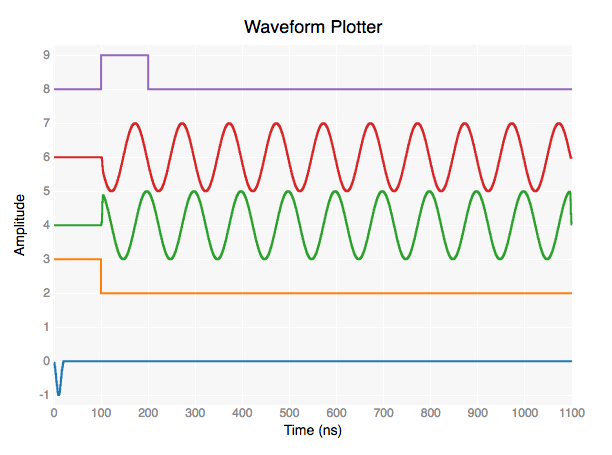